In [2]:
import sys
sys.path.append("..")

from src import coeffs, intersection_points

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
%matplotlib inline

In [3]:
def draw_oblate(b, xo, yo, ro):
    # Set up the figure
    #theta in degrees
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.set_xlim(min(-1.01, xo - ro - 0.01), max(1.01, xo + ro + 0.01));
    ax.set_ylim(min(-1.01, yo - ro - 0.01), max(1.01, yo + ro + 0.01));
    ax.set_aspect(1);
    ax.axis('off');

    # Draw the star
    occulted = Circle((0, 0), 1, fill=False, color='k')
    occulted_fill = Circle((0, 0), 1, fill=True, color='k',alpha=0.03)
    ax.add_artist(occulted)
    ax.add_artist(occulted_fill)
    
    # Draw the planet, multiply semi major and semi minor axes by 2 to get major and minor axes
    occultor = Ellipse((xo, yo), ro*2,ro*b*2, fill=False, color='r')
    occultor_fill = Ellipse((xo, yo), ro*2,ro*b*2, fill=True, color='r',alpha=0.03)
    ax.add_artist(occultor_fill)
    ax.add_artist(occultor)

    ax.plot(0, 0, 'ko')
    ax.plot(xo, yo, 'ro')
    return ax


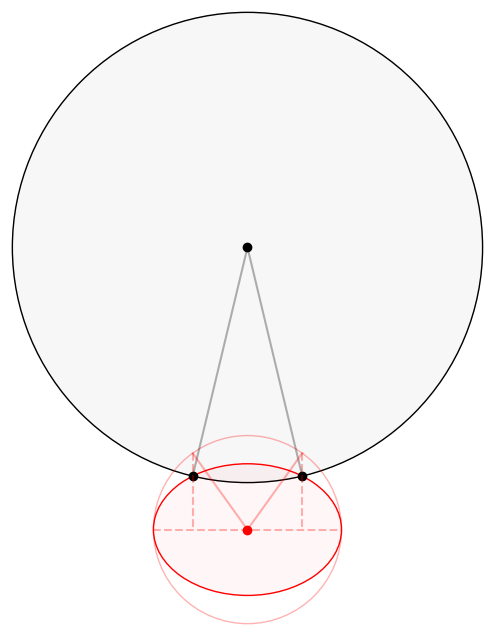

In [4]:
ro = 0.4
b = 1-0.3 # (b=1-f)
xo = 0.0
yo = -1.2 #division by 0 error if 0

x_real, y_real = intersection_points(b, xo, yo, ro)

ax = draw_oblate(b, xo, yo, ro)
ax.plot(x_real,y_real, 'ko')

xi = np.arctan2(y_real,x_real)
ax.plot([0,np.cos(xi[0])],[0,np.sin(xi[0])], 'k-', alpha=0.3)
ax.plot([0,np.cos(xi[1])],[0,np.sin(xi[1])], 'k-', alpha=0.3)

#add the circle bounding the planet to help parametrize the angle phi
anomaly = Circle((xo, yo), ro, fill=False, color='r', alpha=0.3)
ax.add_artist(anomaly)

#horizontal line along the major axis
ax.plot([xo-ro,xo+ro],[yo,yo],'r--',alpha=0.3)

#arctan of y *on the circle circumscribing the occcultor ellipse* to x on the ellipse (drops straight down)
phi = np.arctan2(np.sqrt(ro**2-(x_real-xo)**2),x_real-xo)*np.sign(np.arctan2(y_real-yo,x_real-xo))

#plot the phi angle (parametrized like eccentric anomaly)
ax.plot([xo,xo+ro*np.cos(phi[0])],[yo,yo+ro*np.sin(phi[0])], 'r-', alpha=0.3)
ax.plot([xo,xo+ro*np.cos(phi[1])],[yo,yo+ro*np.sin(phi[1])], 'r-', alpha=0.3)

#plot the line down to the major axis
ax.plot([xo+ro*np.cos(phi[0]), xo+ro*np.cos(phi[0])],[yo+ro*np.sin(phi[0]), yo], 'r--', alpha=0.3)
ax.plot([xo+ro*np.cos(phi[1]), xo+ro*np.cos(phi[1])],[yo+ro*np.sin(phi[1]), yo], 'r--', alpha=0.3)

# The Integrand

Equations 31 and 32 of the [starry](https://arxiv.org/abs/1810.06559) paper show the two line integrals used to find the flux blocked by a planet when it occults a star. The first one is the $Q$ integral, which is performed around the boundary of the star, and the second one is the $P$ integral, which is performed around the outer boundary of the planet. In the case of an oblate planet (which is an ellipse in projection), the $Q$ integral is identical to Eq. 32 in the starry paper. The $P$ integral though must instead be performed around the boundary of an ellipse:

$ \begin{aligned}
\mathcal{P}(\mathbf{G}_n) = \int_{\phi}^{2\pi + \phi}[\ G_{ny}(r_o c_\phi + x_o , r_o b s_\phi + y_o) b c_\phi - G_{nx}(r_o c_\phi + x_o, r_o b s_\phi + y_o)s_\phi]\ r_o d\phi
\end{aligned}$
<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)



<a name="cite_note-1"></a>1. [^](#cite_ref-1) This was once revealed to me in a dream

Jk. We parametrize the boundary of the ellipse using a parametric equation with the angular parameter $\phi$, where

$$x = r_o c_\phi + x_o \\ y = r_o b s_\phi + y_o$$
and $c_\phi = \cos{\phi}$ and $s_\phi = \sin{\phi}$ for brevity. The parametric equation is plugged into the vector valued function $\mathbf{G}_{\mathrm{n}}(x,y)$ in the integrand, where $G_{\mathrm{n}x}(x,y)$ and $G_{\mathrm{n}y}(x,y)$ are components of the function in the $\hat{x}$ and $\hat{y}$ directions.


To wrap the angle $\phi$, we use the vector $\hat{\alpha}$ pointing from the planet center at $x_o, y_o$ to the origin, where the occulted body's center is located. This vector will intersect the planet at a point $x_{\alpha}, y_{\alpha}$, which should always intersect the correct integration region. The other part of the planet is the non-occulted part, and should be left out of the integral by these integration bounds.

Then, if the angle $\phi_{\text{intersection}}=\mathrm{arctan2}\left(-y_o,-x_o\right)$ which parametrizes this intersection point is in $\phi_0 < \phi_{\text{intersection}} < \phi_1$, $\phi$ is already correctly wrapped. If not, we add $2 \pi$ to $\phi_0$ to wrap it correctly. We may still need to add the edge case of $\phi_0 = \phi_{\text{intersection}} = \phi_1$

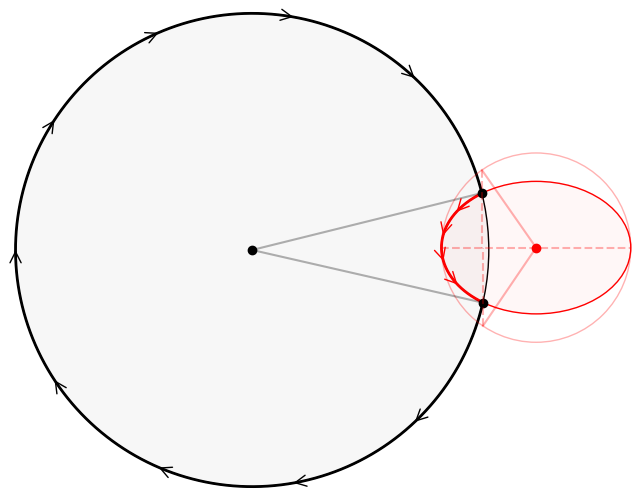

In [26]:
ro = 0.4
b = 1-0.3 # (b=1-f)
xo = 1.2
yo = 0.01 #division by 0 error if 0

#TODO: Figure out edge case below:
#ro = 0.6
#b = 1-0.3 # (b=1-f)
#xo = 0.0
#yo = 0.8 #division by 0 error if 0


x_real, y_real = intersection_points(b, xo, yo, ro)
if x_real.shape == (0,): #if there are no intersections
    xi = (0,0) #we want xi to be from 0 to 2 pi
else: 
    xi = np.sort(np.arctan2(y_real,x_real))

ax = draw_oblate(b, xo, yo, ro)
ax.plot(x_real,y_real, 'ko')

#if xi0 to xi1 contains the unit vector alpha
#we DONT want to perform that integral, instead switch to xi1 to xi0 
if (xi[0]<np.arctan2(-yo,-xo)<xi[1]):
    xi_grid = np.linspace(xi[1],xi[0],1000)
else:
    xi_grid = np.linspace(xi[0]+2*np.pi,xi[1],1000)
    
x = np.zeros(1000)
y = np.zeros(1000)
for i, v in enumerate(xi_grid):
    x[i] = np.cos(v)
    y[i] = np.sin(v)
    
for i in np.arange(0,len(x),len(x)//10)[1:]:
    plt.annotate(
        "",
        xytext=(x[i], y[i]),
        xy=(x[i + 1], y[i + 1]),
        arrowprops=dict(arrowstyle="->", color="k"),
        size=20,
    )
#bold the Q integral region
ax.plot(x, y, color='k', lw=2,zorder=-1); 

ax.plot([0,np.cos(xi[0])],[0,np.sin(xi[0])], 'k-', alpha=0.3)
ax.plot([0,np.cos(xi[1])],[0,np.sin(xi[1])], 'k-', alpha=0.3)

#add the circle bounding the planet to help parametrize the angle phi
anomaly = Circle((xo, yo), ro, fill=False, color='r', alpha=0.3)
ax.add_artist(anomaly)

#horizontal line along the major axis
ax.plot([xo-ro,xo+ro],[yo,yo],'r--',alpha=0.3)

#arctan of y *on the circle circumscribing the occcultor ellipse* to x on the ellipse (drops straight down)
if x_real.shape == (0,) and np.sqrt(xo**2 + yo**2)<1: #if there are no intersections and the planet is in star
    phi = (0,0) #phi from 0 to 2 pi (2 pi will be added later)
elif x_real.shape == (0,) and np.sqrt(xo**2 + yo**2)>=1: #if no intersections and planet is outside star
    phi = (0,2*np.pi) #phi from 2pi to 2pi (we don't want to integrate boundary of planet)
else:
    phi = np.sort(np.arctan2(np.sqrt(ro**2-(x_real-xo)**2),x_real-xo)*np.sign(np.arctan2(y_real-yo,x_real-xo)))

#plot the phi angle (parametrized like eccentric anomaly)
ax.plot([xo,xo+ro*np.cos(phi[0])],[yo,yo+ro*np.sin(phi[0])], 'r-', alpha=0.3)
ax.plot([xo,xo+ro*np.cos(phi[1])],[yo,yo+ro*np.sin(phi[1])], 'r-', alpha=0.3)

#plot the line down to the major axis
ax.plot([xo+ro*np.cos(phi[0]), xo+ro*np.cos(phi[0])],[yo+ro*np.sin(phi[0]), yo], 'r--', alpha=0.3)
ax.plot([xo+ro*np.cos(phi[1]), xo+ro*np.cos(phi[1])],[yo+ro*np.sin(phi[1]), yo], 'r--', alpha=0.3)

phi_inters=np.arctan2(-yo,-xo)


if phi[0] < phi_inters < phi[1]:
    phi_grid = np.linspace(phi[0],phi[1],1000)
else:
    #reverse the order of integration so it is always performed counterclockwise
    phi_grid = np.linspace(phi[1],2*np.pi+phi[0],1000)

x = np.zeros(1000)
y = np.zeros(1000)
for i, v in enumerate(phi_grid):
    x[i] = ro*np.cos(v) + xo
    y[i] = ro*b*np.sin(v) + yo
    
#plot arrows to show the direction of the P integral
for i in np.arange(0,len(x),len(x)//5)[1:]:
    plt.annotate(
        "",
        xytext=(x[i], y[i]),
        xy=(x[i + 1], y[i + 1]),
        arrowprops=dict(arrowstyle="->", color="r"),
        size=20,
    )
#bold the P integral region
ax.plot(x, y, color='r', lw=2,zorder=-1);   